<a href="https://colab.research.google.com/github/ngockhanh5110/nlp-vietnamese-text-summarization/blob/main/notebooks/inferencing_vietnews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Overview: The code below is for the purpose of comparing the quality of the algorithms Lsa, KL, LexRank, TextRank, SumBasic, Luhn with the model I trained**

# **Connect to drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Install lib**

In [ ]:
!pip install vncorenlp datasets==1.0.2
!pip install transformers
!pip install dill==0.3.5.1



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 31.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.2 MB/s eta 0:00:00
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645933 sha256=19b38db16976faaf2f26495ad042586053d531cb014d67ffdfebb5a75e0938f9
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install git-python==1.0.3
# !pip install sacrebleu==1.4.12
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=53149c4278dd1a7f9eecb9ee1c074403507de437838d46b47ad57359a94bebfa
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import os
new_path = "/content/drive/MyDrive/LLM_TEXT/"
os.chdir(new_path)
current_path = os.getcwd()
print("current path:", current_path)

current path: /content/drive/MyDrive/LLM_TEXT


In [ ]:
import glob
import pandas as pd
import concurrent.futures
from datasets import *
import datasets
import transformers
import nltk
nltk.download('punkt')

from transformers import RobertaTokenizerFast,AutoTokenizer
from seq2seq_trainer import Seq2SeqTrainer
from transformers import TrainingArguments
from dataclasses import dataclass, field
from typing import Optional

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
!pip install sumy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 70.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21696 sha256=1c76149b64ef17a03f53b5a664509e6a4ac74d7a7c5a39bd3a85f6c4fd0f0583
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=dbcdea3b496bbfc6e355aaf77639d2f139680e90e0e9ddf0f883073309d539ca
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=1068

# **Processing data**

In [ ]:
size_data_test = 10

In [ ]:
def listPaths(path):
  pathfiles = list()
  cnt = 0
  for pathfile in glob.glob(path):
    cnt += 1
    pathfiles.append(pathfile)
    if cnt == size_data_test:
       break
  return pathfiles

test_paths = listPaths('/content/drive/MyDrive/LLM_TEXT/dataset/meeting/*.txt')
for file in test_paths:
  print(file)

/content/drive/MyDrive/LLM_TEXT/dataset/meeting/002.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/012.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/021.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/030.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/019.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/011.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/005.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/020.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/016.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/029.txt


In [ ]:
def read_content(path_file):
  """
  Input: Path of txt file
  Output
  """

  # print("\n\n path_file:", path_file)
  summary_content = ""
  summary_task = ""
  original = ""

  with open(path_file, "r", encoding="utf-8") as file:
      lines  = file.readlines()
      cnt = 0
      for line in lines:
          line = line.strip()

          if line.startswith("NOI_DUNG_TOM_TAT"):
              cnt = 1
              line = line.replace("NOI_DUNG_TOM_TAT", "")
              line = line.replace(":", "")
          elif line.startswith("NHIEM_VU"):
              cnt = 2
              line = line.replace("NHIEM_VU", "")
              line = line.replace(":", "")
          elif line.startswith("NOI_DUNG_GOC"):
              cnt = 3
              line = line.replace("NOI_DUNG_GOC", "")
              line = line.replace(":", "")
          if line:
            if cnt == 1:
              summary_content += line
            elif cnt == 2:
              summary_task += line
            elif cnt == 3:
              original += line

  # print("summary_content:", summary_content)
  # print("summary_task:", summary_task)
  # print("original:", original)
  return {'file' : path_file,
          'summary_task': summary_task,
          'summary_content': summary_content,
          'original': original}

In [ ]:
def get_stop_words_vn(path):
    ret = []
    # path = "/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt"
    f = open(path, "r")
    lines = f.readlines()
    for line  in lines:
       line = line.replace("_", " ")
       line = " " + line.replace("\n", "") + " "
       ret.append(line)
    return ret

stop_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt")
task_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-task-dash.txt")
# print("stop_words", stop_words)
print("task_words", task_words)

task_words [' nhiệm vụ ', ' đảm nhiệm vai trò ', ' đảm nhận vai trò ', ' đảm nhận công việc ', ' đảm nhiệm nhiệm vụ ', ' được phân công việc ', ' được giao công việc ', ' đã giao cho ', ' phụ trách công việc ', ' sẽ giao công việc ', ' sẽ phân công việc ', ' phân công công việc ', ' sẽ tiến hành ']


In [ ]:
import nltk
from nltk import sent_tokenize
# nltk.download('punkt')

def process_content_sentences( body: str, min_length=5, max_length=50):
        # for word in reversed(stop_words):
        #   body.replace(word, " ")
        sents = [s.strip() for s in sent_tokenize(body)]
        return [c for c in sents if max_length > len(c.split(" ")) > min_length]

def detectTask(str):
  sentences = process_content_sentences(str, 1, 400)
  ret = ""
  for sentence in sentences:
    sentence = sentence.lower()
    for wTask in task_words:
      if wTask.strip() in sentence:
        # for word in reversed(stop_words):
        #   sentence = sentence.replace(word, " ")
        for word in reversed(stop_words):
          sentence = sentence.replace(word, " ")
        # print(sentence)
        ret += sentence
        break
  return ret

In [ ]:
txt = read_content("/content/drive/MyDrive/LLM_TEXT/dataset/meeting/023.txt")
print("summary_task: ", txt["summary_task"])
print ("result: ",detectTask(txt["summary_task"]))

summary_task:  Tú hoàn thành một phần công việc và đã gửi bản thiết kế sơ bộ cho mọi người xem qua qua email.Huy do hoàn cảnh gia đình, tôi không thể làm việc đúng tiến độ. Hiện tại, tôi đã hoàn thành 70% thiết kế trang chủ và sẽ gửi bản tóm tắt cho mọi người trong vòng 24 giờ tớTrọng sẽ tổ chức một cuộc họp nhỏ sau cuộc họp này để xác định lịch trình và phân công công việc. Trang thiết kế giao diện lịch sử giao dịch trên trang web quản lý chi tiêu.   Giao diện lịch sử giao dịch nên hiển thị danh sách các giao dịch trước đây của người dùng, kèm theo thông tin chi tiết và tiện ích tìm kiếm. Thời hạn  hoàn thành trong vòng 7 ngày.Huy  Nhiệm vụ  Thiết kế giao diện quản lý tài khoản trên trang web quản lý chi tiêu. Thời gian trong vòng  12 ngày .Trọng sẽ tiến hành giao việc thiết kế giao diện thông tin cá nhân của người dùng cho trang web quản lý chi tiêu, đã chuẩn bị một mô tả công việc chi tiết.Tú sẽ thiết kế trang cá nhân cho người dùng. Giao diện này nên cho phép người dùng cập nhật th

In [ ]:
def get_dataframe(pathfiles):
  with concurrent.futures.ProcessPoolExecutor() as executor:
    data = executor.map(read_content, pathfiles)

  # Make blank dataframe
  data_df = list()
  for d in data:
    data_df.append(d)
  data_df = pd.DataFrame(data_df)
  data_df.dropna(inplace = True)
  data_df = data_df.sample(frac=1).reset_index(drop=True)

  return data_df

In [ ]:
test_df = get_dataframe(test_paths)
print ("test_df", test_df["summary_task"], test_df["summary_content"] )

test_df 0    Lam sẽ đảm nhận vai trò chính trong việc phát ...
1    Linh: Chủ tọa cuộc họp, giao việc cho các thàn...
2    Đơn vị quản lý A phụ trách công việc phân tích...
3    Tuấn đã  thiết kế và hoàn thiện một số phần củ...
4    Đồng chí Hà  sẽ tiến hành xây dựng  kế hoạch b...
5    Đồng chí chủ tịch công đoàn  sẽ tiến hành xây ...
6    Chủ tịch công đoàn :  Tiến hành xây dựng  kế h...
7    Hà  sẽ tiến hành xây dựng  kế hoạch bài dạy đư...
8    Phương sẽ đảm nhận vai trò chính trong việc th...
9    Quyên sẽ đảm nhận vai trò chính trong việc thi...
Name: summary_task, dtype: object 0    Phân công nhiệm vụ code chức năng review cho h...
1    Trong cuộc họp giao việc cho ba thành viên tro...
2    Dưới đây là phân công công việc cho dự án thiế...
3    Báo cáo tiến độ thiết kế giao diện cho trang w...
4    Phân công công việc cho việc xây dựng chuyên đ...
5    Phân công công nhiệm vụ  cho việc xây dựng côn...
6    Phân công công nhiệm vụ  cho việc xây dựng côn...
7    Phân công công việ

In [ ]:
test_data =  Dataset.from_pandas(test_df)

In [ ]:
# load rouge for validation
rouge = datasets.load_metric("rouge")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

# **Inference**

In [ ]:
path_result = "/content/drive/MyDrive/LLM_TEXT/inference/infer_2/"
RATIO = 0.2
listAlorithms = ['KLSummarizer','LexRankSummarizer','LsaSummarizer','LuhnSummarizer','SumBasicSummarizer','TextRankSummarizer']
models = listAlorithms
rouge1_recall = []
rouge1_precision = []
rouge1_f1 = []
rouge2_recall = []
rouge2_precision = []
rouge2_f1 = []
rougel_recall = []
rougel_precision = []
rougel_f1 = []

In [ ]:
def getRougeMyModel(rouge_output):
   for key,value in rouge_output.items():
      if key == "rouge1":
         rouge1_recall.append(value.mid[0])
         rouge1_precision.append(value.mid[1])
         rouge1_f1.append(value.mid[2])
         print('rouge1:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rouge2":
         rouge2_recall.append(value.mid[0])
         rouge2_precision.append(value.mid[1])
         rouge2_f1.append(value.mid[2])
         print('rouge2:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rougeL":
         rougel_recall.append(value.mid[0])
         rougel_precision.append(value.mid[1])
         rougel_f1.append(value.mid[2])
         print('rougeL:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])

## **With my model**

In [ ]:
myModelName = 'Custom "Custom PhoBERT"'

In [ ]:
import datasets
from transformers import RobertaTokenizer, EncoderDecoderModel, AutoTokenizer
from sklearn.model_selection import train_test_split


tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

model = EncoderDecoderModel.from_pretrained('/content/drive/MyDrive/LLM_TEXT/training/checkpoint-30000')
model.to("cpu")
batch_size = 32  # change to 64 for full evaluation

# map data correctly
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    inputs = tokenizer(batch["original"], padding="max_length", truncation=True, max_length=256, return_tensors="pt")
    input_ids = inputs.input_ids.to("cpu")
    attention_mask = inputs.attention_mask.to("cpu")

    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']


In [ ]:

results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["original"])

result_summary_content = results["pred"]
summary_content_original = results["summary_content"]
summary_task_original = results["summary_task"]


print ("result_summary_content: ",result_summary_content[0] )

print ("file: ",test_data[0]["file"]  )
print ("summary_conten: ",summary_content_original[0] )
print ("summary_task: ",summary_task_original[0] )
print ("original: ",test_data[0]["original"] )

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

result_summary_content:  Trong ban điều_hành, các nhân_viên của công_ty có_thể tự quyết_định công_việc của mình, trong đó có việc đảm_bảo chất_lượng đầu_ra cho các sản_phẩm.
file:  /content/drive/MyDrive/LLM_TEXT/dataset/meeting/002.txt
summary_conten:  Phân công nhiệm vụ code chức năng review cho hai thành viên trong nhóm.
summary_task:  Lam sẽ đảm nhận vai trò chính trong việc phát triển phần giao diện người dùng (UI) của chức năng review, bao gồm: Thiết kế giao diện đánh giá món ăn và hiển thị các đánh giá hiện có. Tạo các thành phần UI như form đánh giá, hiển thị điểm số và ý kiến của người dùng. Deadline: 1 tuầnNgọc sẽ đảm nhận nhiệm vụ xử lý và lưu trữ dữ liệu đánh giá trong phần backend. Xây dựng API để gửi và nhận dữ liệu đánh giá từ giao diện người dùng. Lưu trữ dữ liệu đánh giá vào cơ sở dữ liệu và cập nhật điểm số trung bình của món ăn. Deadline: 1 tuần sau khi thành viên Lam hoàn thành nhiệm vụ của mình
original:  Ngày 20/6/2023 diễn ra cuộc họp giao nhiệm vụ củ của công ty

In [ ]:
result_summary_task = []
for data in test_df["original"]:
  ret_task = detectTask(data)
  result_summary_task.append(ret_task)
  print("data", data)
  print('--->',ret_task, "\n")

data Ngày 20/6/2023 diễn ra cuộc họp giao nhiệm vụ củ của công ty Mạnh Thắng của chúng ta, chúng ta đã quyết định phân công nhiệm vụ code chức năng review cho hai thành viên trong nhóm. Dưới đây là phân công cụ thể và deadline cho mỗi thành viên: Lam sẽ đảm nhận vai trò chính trong việc phát triển phần giao diện người dùng (UI) của chức năng review. Nhiệm vụ của anh ta bao gồm: Thiết kế giao diện đánh giá món ăn và hiển thị các đánh giá hiện có. Tạo các thành phần UI như form đánh giá, hiển thị điểm số và ý kiến của người dùng. Deadline: 1 tuần từ ngày hôm nay. Ngọc  sẽ đảm nhận nhiệm vụ xử lý và lưu trữ dữ liệu đánh giá trong phần backend. Anh ta sẽ thực hiện các công việc sau: Xây dựng API để gửi và nhận dữ liệu đánh giá từ giao diện người dùng. Lưu trữ dữ liệu đánh giá vào cơ sở dữ liệu và cập nhật điểm số trung bình của món ăn. Deadline: 1 tuần sau khi thành viên Lam hoàn thành nhiệm vụ của mình. Chúng ta sẽ thiết lập các cuộc họp định kỳ để theo dõi tiến độ và giải quyết các vấn đ

## **Inference data with algorithms** [Lsa, KL, LexRank, TextRank, SumBasic, Luhn]

In [ ]:
import os
import re

def write_data(folder, offset, index, content):
  path = folder+"/summary_{:06d}.txt".format(offset+index+1)
  f = open(path, "w")
  f.write(content)
  f.close()

def folderExist(folder_path):
  if not os.path.exists(folder_path):
      os.makedirs(folder_path)

def clean_text(text):
  text = text.replace("\n"," ")
  text = re.sub("\s\s+"," ",text)
  text = text.replace("TP.", "TP")
  text = re.sub("\.\.+",".",text)
  text = re.sub("…",".",text)
  all_number = re.findall("\d*\.\d+",text)
  all_dot = re.findall("[A-Z|Ê|Ư|Ơ|Â|Ă|Đ]\s*\.", text)
  text_dot = re.findall("\.\s+[^A-Z|Ê|Ư|Ơ|Â|Ă|Đ]", text)
  for w in all_number:
    text = text.replace(w, w.replace(".",""))
  for w in all_dot:
    text = text.replace(w, w.replace(".",""))
  for w in text_dot:
    text = text.replace(w, w.replace(".",""))
  text = re.sub(r"[()\"#@:<>{}`+=~|!“”]", "", text)
  print("allnumber:",all_number)
  print("all_dot",all_dot)
  print('text_dot:',text_dot)
  return text

def load_sum(model, content, index):
  name_model = str(type(model)).split(".")[-1].replace("'>","")
  result = ''
  path = path_result + name_model
  folderExist(path)
  lenght = len(parser.document.sentences)
  count = 1 if RATIO * lenght < 1 else lenght * RATIO
  for sentence in model(content, count):
      result += str(sentence) +" "
  write_data(path, 0, idx, result)

In [ ]:
class TokenizerVNVal:
    @staticmethod
    def to_sentences(text: str):
        return [s.strip() for s in text.split(".")]
    @staticmethod
    def to_words(sentence: str):
        # sentence = sentence.replace("_", " ")
        return [w.strip() for w in sentence.split(" ")]

In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.utils import get_stop_words
import nltk

SENTENCES_COUNT = 3
path_file_stopword = "/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt"
# print(test_df)
if __name__ == "__main__":

    # or for plain text files
    # parser = PlaintextParser.from_file("document.txt", Tokenizer(LANGUAGE))
    # parser = PlaintextParser.from_string("Check this out.", Tokenizer(LANGUAGE))
    lsaSummarizer = LsaSummarizer()
    lsaSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    kLSummarizer = KLSummarizer()
    kLSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    lexRankSummarizer = LexRankSummarizer()
    lexRankSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    luhnSummarizer = LuhnSummarizer()
    luhnSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    textRankSummarizer = TextRankSummarizer()
    textRankSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    sumBasicSummarizer = SumBasicSummarizer()
    sumBasicSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    for idx, originnalTxt in enumerate(test_df["original"]):
        print(idx)
        parser = PlaintextParser.from_string(clean_text(originnalTxt), TokenizerVNVal)
        load_sum(lsaSummarizer, parser.document, idx)
        load_sum(kLSummarizer, parser.document, idx)
        load_sum(lexRankSummarizer, parser.document, idx)
        load_sum(textRankSummarizer, parser.document, idx)
        load_sum(luhnSummarizer, parser.document, idx)
        load_sum(sumBasicSummarizer, parser.document, idx)


    # for sentence in summarizer(parser.document, SENTENCES_COUNT):
    #     print(sentence)

0
allnumber: []
all_dot []
text_dot: []
1
allnumber: []
all_dot []
text_dot: []
2
allnumber: []
all_dot []
text_dot: []
3
allnumber: []
all_dot []
text_dot: []
4
allnumber: []
all_dot []
text_dot: ['. t']
5
allnumber: []
all_dot ['B .']
text_dot: []
6
allnumber: []
all_dot []
text_dot: ['. c']
7
allnumber: []
all_dot []
text_dot: ['. t']
8
allnumber: []
all_dot []
text_dot: []
9
allnumber: []
all_dot []
text_dot: ['. n']


In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from statistics import mean, median

def get_data_evalue(folder, offset, count):
  data = []
  for i in range(count):
    path = folder + "/summary_{:06d}.txt".format(i+offset+1)
    f = open(path, "r")
    lines = f.readlines()
    sum = ""
    for line in lines:
        sum += line.replace("_"," ") + " "
    sum = sum.replace("\n","")
    sum = sum.replace("<q>"," ")
    sum = sum.lower()
    data.append(sum)
  return data

def evalue(model):
    path_sum = path_result +"/" +  model
    data_sum = get_data_evalue(path_sum, 0, size_data_test)
    r1_recall = []
    r1_precision = []
    r1_f = []

    r2_recall= []
    r2_precision = []
    r2_f = []
    rl_sent = []
    rl_sum = []

    print("model: ", model)
    ret_rouge_ = rouge.compute(predictions=data_sum, references=summary_content_original, rouge_types=["rouge1","rouge2","rougeL"])
    # for key,value in ret_rouge_.items():
    #   print(key)
    #   print(value.mid)

    getRougeMyModel(ret_rouge_)

In [ ]:
rouge1_recall = []
rouge1_precision = []
rouge1_f1 = []
rouge2_recall = []
rouge2_precision = []
rouge2_f1 = []
models = listAlorithms
for model in models:
  if model != myModelName:
    evalue(model)


# getRougeMyModel()


model:  KLSummarizer
rouge1:recall 0.35424954976589984 -precision 0.8384420630206649 -F1-Score 0.4698642356931141
rouge2:recall 0.20604606388658142 -precision 0.5472560938865287 -F1-Score 0.5472560938865287
rougeL:recall 0.2673488351733922 -precision 0.6626348492398102 -F1-Score 0.6626348492398102
model:  LexRankSummarizer
rouge1:recall 0.2578832630351043 -precision 0.8978449110950407 -F1-Score 0.37413270224562356
rouge2:recall 0.16165309954992116 -precision 0.5962253557905731 -F1-Score 0.5962253557905731
rougeL:recall 0.19350714707354022 -precision 0.703194835171002 -F1-Score 0.703194835171002
model:  LsaSummarizer
rouge1:recall 0.2977651765994433 -precision 0.8888222854865239 -F1-Score 0.41470733512583857
rouge2:recall 0.15778971479027787 -precision 0.5433529755268885 -F1-Score 0.5433529755268885
rougeL:recall 0.2044844643993718 -precision 0.6439845830249131 -F1-Score 0.6439845830249131
model:  LuhnSummarizer
rouge1:recall 0.1945423817179117 -precision 0.9039673302893447 -F1-Score 0.

# **Evaluation**


In [ ]:
print("Evaluation content")
rouge_summary_content = rouge.compute(predictions=result_summary_content, references=summary_content_original, rouge_types=["rouge1","rouge2","rougeL"])
models.append(myModelName)
getRougeMyModel(rouge_summary_content)


Evaluation content
rouge1:recall 0.5043865548108497 -precision 0.5273020512649309 -F1-Score 0.5021196170112279
rouge2:recall 0.16577795468146778 -precision 0.16344572355441922 -F1-Score 0.16344572355441922
rougeL:recall 0.30698850622237295 -precision 0.3217283944671453 -F1-Score 0.3217283944671453


In [ ]:
print("Evaluation task")
rouge_summary_task = rouge.compute(predictions=result_summary_task, references=summary_task_original, rouge_types=["rouge1","rouge2","rougeL"])
for key,value in rouge_summary_task.items():
  print(key)
  print(value.mid)

Evaluation task
rouge1
Score(precision=0.924839958694108, recall=0.538827064641234, fmeasure=0.6595323858497608)
rouge2
Score(precision=0.6164393989377212, recall=0.35267594604730057, fmeasure=0.4331201211147392)
rougeL
Score(precision=0.6573839985640987, recall=0.3867805787670342, fmeasure=0.47080298851011737)


# **Draw a comparison chart**

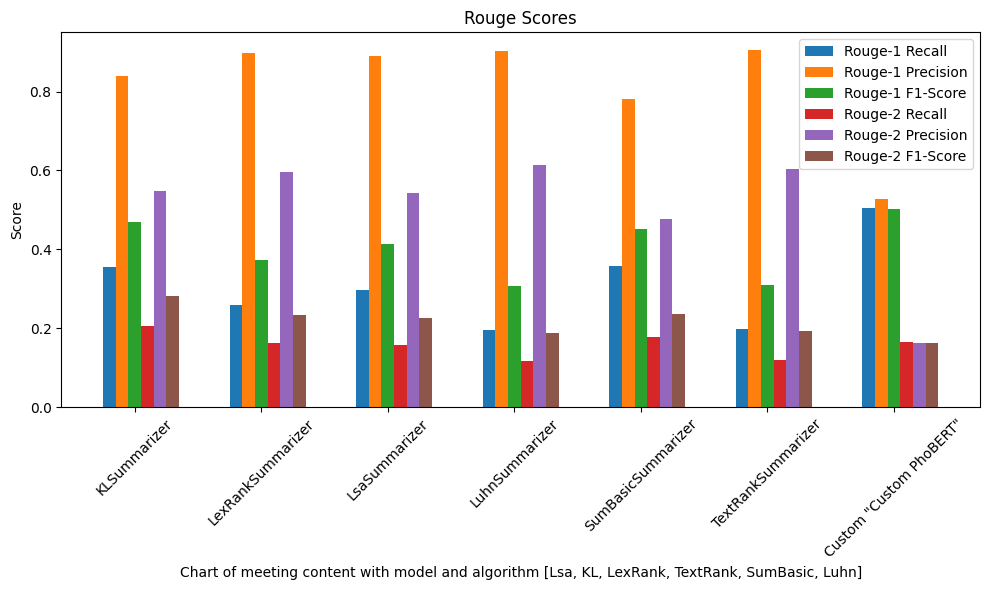

In [ ]:
import matplotlib.pyplot as plt
x = np.arange(len(models))
width = 0.1
plt.figure(figsize=(10, 6))
plt.bar(x, rouge1_recall, width, label='Rouge-1 Recall')
plt.bar(x + width, rouge1_precision, width, label='Rouge-1 Precision')
plt.bar(x + 2 * width, rouge1_f1, width, label='Rouge-1 F1-Score')
plt.bar(x + 3 * width, rouge2_recall, width, label='Rouge-2 Recall')
plt.bar(x + 4 * width, rouge2_precision, width, label='Rouge-2 Precision')
plt.bar(x + 5 * width, rouge2_f1, width, label='Rouge-2 F1-Score')
plt.xlabel('Chart of meeting content with model and algorithm [Lsa, KL, LexRank, TextRank, SumBasic, Luhn]')
plt.ylabel('Score')
plt.title('Rouge Scores')
plt.xticks(x + 2 * width, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
rouge1_recall_task = []
rouge1_precision_task = []
rouge1_f1_task = []
rouge2_recall_task = []
rouge2_precision_task = []
rouge2_f1_task = []
models_task = [""]
for key,value in rouge_summary_task.items():
      if key == "rouge1":
         rouge1_recall_task.append(value.mid[0])
         rouge1_precision_task.append(value.mid[1])
         rouge1_f1_task.append(value.mid[2])
         print('rouge1:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rouge2":
         rouge2_recall_task.append(value.mid[0])
         rouge2_precision_task.append(value.mid[1])
         rouge2_f1_task.append(value.mid[2])
         print('rouge2:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rougeL":
         rougel_recall.append(value.mid[0])
         rougel_precision.append(value.mid[1])
         rougel_f1.append(value.mid[2])
         print('rougeL:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])

rouge1:recall 0.924839958694108 -precision 0.538827064641234 -F1-Score 0.6595323858497608
rouge2:recall 0.6164393989377212 -precision 0.35267594604730057 -F1-Score 0.35267594604730057
rougeL:recall 0.6573839985640987 -precision 0.3867805787670342 -F1-Score 0.3867805787670342


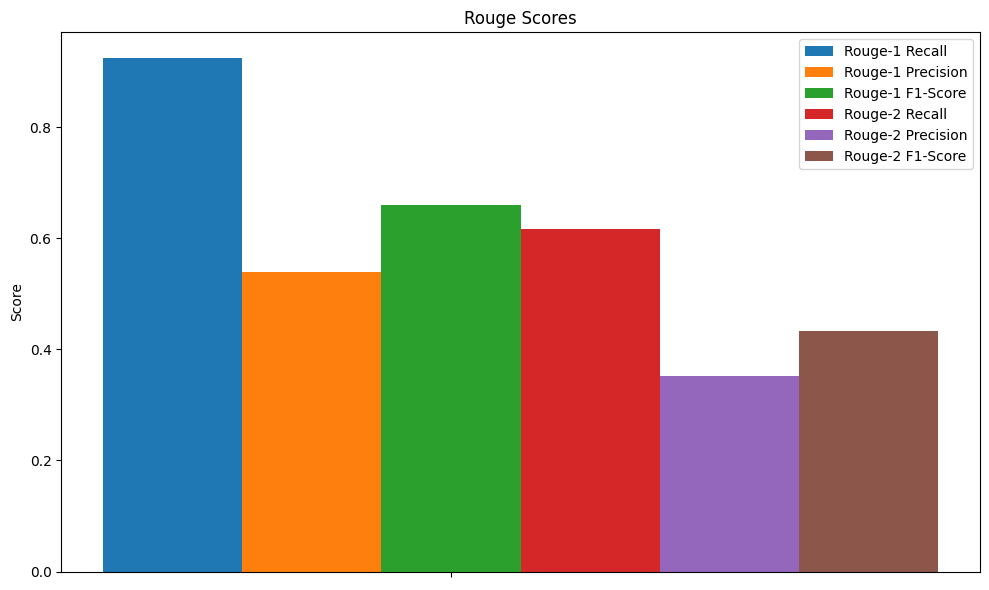

In [ ]:

import matplotlib.pyplot as plt
x = np.arange(len(models_task))
width = 0.1
plt.figure(figsize=(10, 6))
plt.bar(x, rouge1_recall_task, width, label='Rouge-1 Recall')
plt.bar(x + width, rouge1_precision_task, width, label='Rouge-1 Precision')
plt.bar(x + 2 * width, rouge1_f1_task, width, label='Rouge-1 F1-Score')
plt.bar(x + 3 * width, rouge2_recall_task, width, label='Rouge-2 Recall')
plt.bar(x + 4 * width, rouge2_precision_task, width, label='Rouge-2 Precision')
plt.bar(x + 5 * width, rouge2_f1_task, width, label='Rouge-2 F1-Score')
plt.xlabel('')
plt.ylabel('Score')
plt.title('Rouge Scores')
plt.xticks(x + 2 * width, models_task, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()